In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

tam_df = pd.read_csv('')
tam_df

,Authenticity,Processed_news
0,0,பாஸ்வேர்டை பகிரும் பயனர்களிடம் கூடுதல் கட்டணம்...
1,0,இந்தியாவில் நடப்பு ஆண்டின் இறுதிக்குள் ‘ஏகே203...
2,0,பட்ஜெட் விலையில் மோட்டோ e22s ஸ்மார்ட்போன் இந்த...
3,0,கலாம் கண்ட கடைசி கனவை நனவாக்குவோம்
4,0,பட்ஜெட் விலையில் ரெட்மி ஏ1 ஸ்மார்ட்போன் இந்திய...
...,...,...
5221,1,கொரோனா நோயாளி வதந்தி தற்கொலை செய்துகொண்ட கூலித...
5222,1,அமைதியின்மையை விளைவிக்கும் வாட்ஸ்அப் தகவலா குண...
5223,1,’ஓட்டுக்குப் பணம் கொடுத்தாரா முதல்வர்’
5224,1,தகவல் தொழில்நுட்ப சட்டத்தில் புதிய திருத்தம்


# BERT

In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# Check if CUDA is available and set the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom Dataset Class
class fakenewsdetection(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Split data into 85% training+validation and 15% testing
train_val_data, test_data = train_test_split(tam_df, test_size=0.15, random_state=42)

# Step 2: Split the 85% train_val_data into 70% training and 15% validation
train_data, val_data = train_test_split(train_val_data, test_size=0.1765, random_state=42)

# Create datasets for training, validation, and testing
train_dataset = fakenewsdetection(
    reviews=train_data.Processed_news.to_numpy(),
    labels=train_data.Authenticity.to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

val_dataset = fakenewsdetection(
    reviews=val_data.Processed_news.to_numpy(),
    labels=val_data.Authenticity.to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

test_dataset = fakenewsdetection(
    reviews=test_data.Processed_news.to_numpy(),
    labels=test_data.Authenticity.to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

# Data loaders for train, validation, and test sets
train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=RandomSampler(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=32, sampler=SequentialSampler(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=32, sampler=SequentialSampler(test_dataset))

# Load BERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop with validation
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Training step
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}')

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss:.4f}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Training Loss: 0.5599
Epoch 1/10, Validation Loss: 0.5777
Epoch 2/10, Training Loss: 0.4817
Epoch 2/10, Validation Loss: 0.5620
Epoch 3/10, Training Loss: 0.4011
Epoch 3/10, Validation Loss: 0.4371
Epoch 4/10, Training Loss: 0.3421
Epoch 4/10, Validation Loss: 0.3928
Epoch 5/10, Training Loss: 0.2764
Epoch 5/10, Validation Loss: 0.3963
Epoch 6/10, Training Loss: 0.2387
Epoch 6/10, Validation Loss: 0.4058
Epoch 7/10, Training Loss: 0.1978
Epoch 7/10, Validation Loss: 0.4697
Epoch 8/10, Training Loss: 0.1536
Epoch 8/10, Validation Loss: 0.4625
Epoch 9/10, Training Loss: 0.1275
Epoch 9/10, Validation Loss: 0.4951
Epoch 10/10, Training Loss: 0.1089
Epoch 10/10, Validation Loss: 0.6010


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch.nn.functional as F

# Evaluate the BERT model
model.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    token_type_ids = batch.get('token_type_ids', None)
    if token_type_ids is not None:  # Only move token_type_ids to device if present
        token_type_ids = token_type_ids.to(device)
    labels = batch['labels'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    logits = outputs.logits
    preds = torch.argmax(F.softmax(logits, dim=1), dim=1)

    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')

Test Accuracy: 0.8265
Test Precision: 0.8276
Test Recall: 0.8265
Test F1 Score: 0.8267


# RoBERTa

In [ ]:
import pandas as pd
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# Check if CUDA is available and set the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Tokenization
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Custom Dataset Class
class fakenewsdetection(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,  # No token type IDs for RoBERTa
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Step 1: Split data into 85% training+validation and 15% testing
train_val_data, test_data = train_test_split(tam_df, test_size=0.15, random_state=42)

# Step 2: Split the 85% train_val_data into 70% training and 15% validation
train_data, val_data = train_test_split(train_val_data, test_size=0.1765, random_state=42)

# Create datasets for training, validation, and testing
train_dataset = fakenewsdetection(
    reviews=train_data.Processed_news.to_numpy(),
    labels=train_data.Authenticity.to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

val_dataset = fakenewsdetection(
    reviews=val_data.Processed_news.to_numpy(),
    labels=val_data.Authenticity.to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

test_dataset = fakenewsdetection(
    reviews=test_data.Processed_news.to_numpy(),
    labels=test_data.Authenticity.to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

# Data loaders for train, validation, and test sets with batch size 32
train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=RandomSampler(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=32, sampler=SequentialSampler(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=32, sampler=SequentialSampler(test_dataset))

# Load RoBERTa model (no token_type_ids required)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop with validation for 10 epochs
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Training step
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}')

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss:.4f}')


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Training Loss: 0.6845
Epoch 1/10, Validation Loss: 0.6653
Epoch 2/10, Training Loss: 0.6476
Epoch 2/10, Validation Loss: 0.6758
Epoch 3/10, Training Loss: 0.6462
Epoch 3/10, Validation Loss: 0.6783
Epoch 4/10, Training Loss: 0.6413
Epoch 4/10, Validation Loss: 0.6940
Epoch 5/10, Training Loss: 0.6661
Epoch 5/10, Validation Loss: 0.6756
Epoch 6/10, Training Loss: 0.6292
Epoch 6/10, Validation Loss: 0.7146
Epoch 7/10, Training Loss: 0.6479
Epoch 7/10, Validation Loss: 0.6745
Epoch 8/10, Training Loss: 0.6427
Epoch 8/10, Validation Loss: 0.6700
Epoch 9/10, Training Loss: 0.6427
Epoch 9/10, Validation Loss: 0.6697
Epoch 10/10, Training Loss: 0.6453
Epoch 10/10, Validation Loss: 0.6667


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Evaluate the model
model.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Removed token_type_ids
    logits = outputs.logits
    preds = torch.argmax(F.softmax(logits, dim=1), dim=1)

    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')

Test Accuracy: 0.6263
Test Precision: 0.7130
Test Recall: 0.6263
Test F1 Score: 0.5651


#DistilBERT

In [ ]:
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# Check if CUDA is available and set the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Tokenization

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Custom Dataset Class
class fakenewsdetection(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,  # No token type IDs for DistilBERT
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Step 1: Split data into 85% training+validation and 15% testing
train_val_data, test_data = train_test_split(tam_df, test_size=0.15, random_state=42)

# Step 2: Split the 85% train_val_data into 70% training and 15% validation
train_data, val_data = train_test_split(train_val_data, test_size=0.1765, random_state=42)

# Create datasets for training, validation, and testing
train_dataset = fakenewsdetection(
    reviews=train_data.Processed_news.to_numpy(),
    labels=train_data.Authenticity.to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

val_dataset = fakenewsdetection(
    reviews=val_data.Processed_news.to_numpy(),
    labels=val_data.Authenticity.to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

test_dataset = fakenewsdetection(
    reviews=test_data.Processed_news.to_numpy(),
    labels=test_data.Authenticity.to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

# Data loaders for train, validation, and test sets with batch size 32
train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=RandomSampler(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=32, sampler=SequentialSampler(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=32, sampler=SequentialSampler(test_dataset))

# Load DistilBERT model (no token_type_ids required)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop with validation for 10 epochs
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Training step
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}')

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss:.4f}')


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Training Loss: 0.5818
Epoch 1/10, Validation Loss: 0.6102
Epoch 2/10, Training Loss: 0.4894
Epoch 2/10, Validation Loss: 0.4962
Epoch 3/10, Training Loss: 0.4312
Epoch 3/10, Validation Loss: 0.4589
Epoch 4/10, Training Loss: 0.4054
Epoch 4/10, Validation Loss: 0.4457
Epoch 5/10, Training Loss: 0.3409
Epoch 5/10, Validation Loss: 0.4703
Epoch 6/10, Training Loss: 0.3046
Epoch 6/10, Validation Loss: 0.4402
Epoch 7/10, Training Loss: 0.2651
Epoch 7/10, Validation Loss: 0.4026
Epoch 8/10, Training Loss: 0.2261
Epoch 8/10, Validation Loss: 0.4300
Epoch 9/10, Training Loss: 0.1896
Epoch 9/10, Validation Loss: 0.5266
Epoch 10/10, Training Loss: 0.1709
Epoch 10/10, Validation Loss: 0.5757


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Evaluate the DistilBERT model
model.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    preds = torch.argmax(F.softmax(logits, dim=1), dim=1)

    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')

Test Accuracy: 0.8036
Test Precision: 0.8088
Test Recall: 0.8036
Test F1 Score: 0.8013


# ALBERT

In [ ]:
import pandas as pd
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# Check if CUDA is available and set the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Tokenization
from transformers import AlbertTokenizer

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Custom Dataset Class
class fakenewsdetection(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,  # ALBERT uses token_type_ids
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),  # Add token_type_ids for ALBERT
            'labels': torch.tensor(label, dtype=torch.long)
        }


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Step 1: Split data into 85% training+validation and 15% testing
train_val_data, test_data = train_test_split(tam_df, test_size=0.15, random_state=42)

# Step 2: Split the 85% train_val_data into 70% training and 15% validation
train_data, val_data = train_test_split(train_val_data, test_size=0.1765, random_state=42)

# Create datasets for training, validation, and testing
train_dataset = fakenewsdetection(
    reviews=train_data.Processed_news.to_numpy(),
    labels=train_data.Authenticity.to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

val_dataset = fakenewsdetection(
    reviews=val_data.Processed_news.to_numpy(),
    labels=val_data.Authenticity.to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

test_dataset = fakenewsdetection(
    reviews=test_data.Processed_news.to_numpy(),
    labels=test_data.Authenticity.to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

# Data loaders for train, validation, and test sets with batch size 32
train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=RandomSampler(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=32, sampler=SequentialSampler(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=32, sampler=SequentialSampler(test_dataset))

# Load ALBERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop with validation for 10 epochs
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Training step
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)  # ALBERT uses token_type_ids
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}')

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)  # ALBERT uses token_type_ids
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss:.4f}')


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Training Loss: 0.5723
Epoch 1/10, Validation Loss: 0.5482
Epoch 2/10, Training Loss: 0.5169
Epoch 2/10, Validation Loss: 0.5584
Epoch 3/10, Training Loss: 0.5055
Epoch 3/10, Validation Loss: 0.5129
Epoch 4/10, Training Loss: 0.4835
Epoch 4/10, Validation Loss: 0.5202
Epoch 5/10, Training Loss: 0.4687
Epoch 5/10, Validation Loss: 0.5318
Epoch 6/10, Training Loss: 0.4591
Epoch 6/10, Validation Loss: 0.5162
Epoch 7/10, Training Loss: 0.4562
Epoch 7/10, Validation Loss: 0.5115
Epoch 8/10, Training Loss: 0.4433
Epoch 8/10, Validation Loss: 0.5233
Epoch 9/10, Training Loss: 0.4416
Epoch 9/10, Validation Loss: 0.5379
Epoch 10/10, Training Loss: 0.4312
Epoch 10/10, Validation Loss: 0.5439


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch.nn.functional as F

# Evaluate the ALBERT model
model.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    token_type_ids = batch['token_type_ids'].to(device)  # Include token_type_ids for ALBERT
    labels = batch['labels'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    logits = outputs.logits
    preds = torch.argmax(F.softmax(logits, dim=1), dim=1)

    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')

Test Accuracy: 0.6939
Test Precision: 0.7314
Test Recall: 0.6939
Test F1 Score: 0.6725


#DeBERTa

In [ ]:
import pandas as pd
from transformers import DebertaTokenizer, DebertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# Check if CUDA is available and set the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Tokenization
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

# Custom Dataset Class
class fakenewsdetection(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Step 1: Split data into 85% training+validation and 15% testing
train_val_data, test_data = train_test_split(tam_df, test_size=0.15, random_state=42)

# Step 2: Split the 85% train_val_data into 70% training and 15% validation
train_data, val_data = train_test_split(train_val_data, test_size=0.1765, random_state=42)

# Create datasets for training, validation, and testing
train_dataset = fakenewsdetection(
    reviews=train_data.Processed_news.to_numpy(),
    labels=train_data.Authenticity.to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

val_dataset = fakenewsdetection(
    reviews=val_data.Processed_news.to_numpy(),
    labels=val_data.Authenticity.to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

test_dataset = fakenewsdetection(
    reviews=test_data.Processed_news.to_numpy(),
    labels=test_data.Authenticity.to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

# Data loaders for train, validation, and test sets with batch size 32
train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=RandomSampler(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=32, sampler=SequentialSampler(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=32, sampler=SequentialSampler(test_dataset))

# Load DeBERTa model (no token_type_ids required)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=2)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop with validation for 10 epochs
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Training step
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}')

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss:.4f}')


pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Training Loss: 0.6860
Epoch 1/10, Validation Loss: 0.6498
Epoch 2/10, Training Loss: 0.6437
Epoch 2/10, Validation Loss: 0.6701
Epoch 3/10, Training Loss: 0.5882
Epoch 3/10, Validation Loss: 0.5961
Epoch 4/10, Training Loss: 0.5316
Epoch 4/10, Validation Loss: 0.6107
Epoch 5/10, Training Loss: 0.5026
Epoch 5/10, Validation Loss: 0.5791
Epoch 6/10, Training Loss: 0.4883
Epoch 6/10, Validation Loss: 0.5339
Epoch 7/10, Training Loss: 0.4538
Epoch 7/10, Validation Loss: 0.5031
Epoch 8/10, Training Loss: 0.4202
Epoch 8/10, Validation Loss: 0.4982
Epoch 9/10, Training Loss: 0.3842
Epoch 9/10, Validation Loss: 0.5112
Epoch 10/10, Training Loss: 0.3651
Epoch 10/10, Validation Loss: 0.4802


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch.nn.functional as F

# Evaluate the DeBERTa model
model.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    preds = torch.argmax(F.softmax(logits, dim=1), dim=1)

    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')

Test Accuracy: 0.8163
Test Precision: 0.8163
Test Recall: 0.8163
Test F1 Score: 0.8160


# Comparison of Models on Accuracy, Precision, Recall, and F1-Score

In [ ]:
import pandas as pd

results = {
    'Model': ['BERT', 'RoBERTa', 'DistilBERT', 'ALBERT', 'DeBERTa'],
    'Accuracy': [0.8265, 0.6263, 0.8036, 0.6939, 0.8163],
    'Precision': [0.8276, 0.7130, 0.8088, 0.7314, 0.8163],
    'Recall': [0.8265, 0.6263, 0.8036, 0.6939, 0.8163],
    'F1-Score': [0.8267, 0.5651, 0.8013, 0.6725, 0.8160]
}

df = pd.DataFrame(results)
df

,Model,Accuracy,Precision,Recall,F1-Score
0,BERT,0.8265,0.8276,0.8265,0.8267
1,RoBERTa,0.6263,0.7130,0.6263,0.5651
2,DistilBERT,0.8036,0.8088,0.8036,0.8013
3,ALBERT,0.6939,0.7314,0.6939,0.6725
4,DeBERTa,0.8163,0.8163,0.8163,0.8160


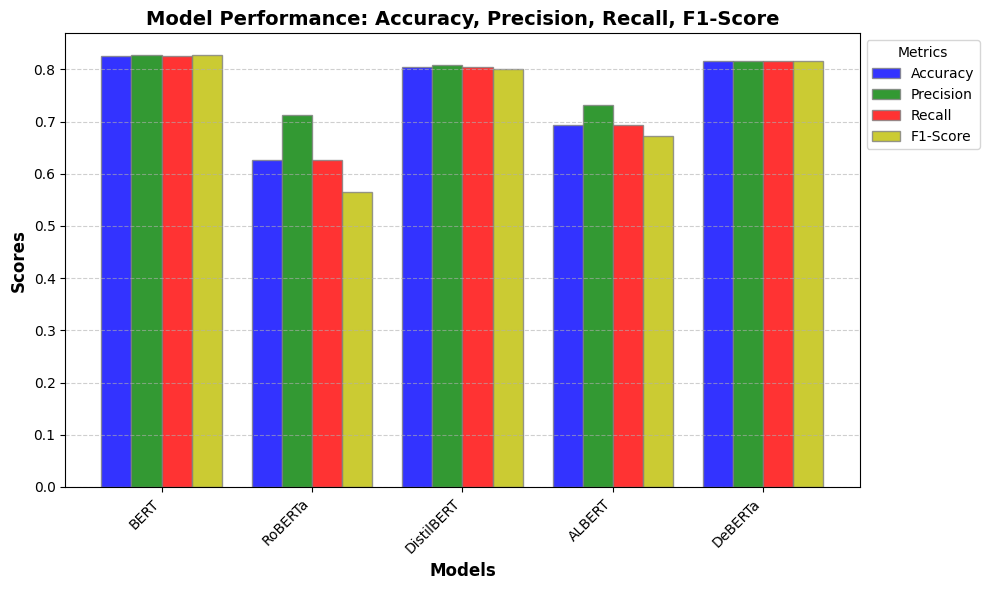

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
models = results['Model']
accuracy = results['Accuracy']
precision = results['Precision']
recall = results['Recall']
f1_score = results['F1-Score']

# Set width of bars and the position of each group of bars
bar_width = 0.2
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the bars with transparency for better visualization
plt.figure(figsize=(10, 6))
plt.bar(r1, accuracy, color='b', width=bar_width, edgecolor='grey', label='Accuracy', alpha=0.8)
plt.bar(r2, precision, color='g', width=bar_width, edgecolor='grey', label='Precision', alpha=0.8)
plt.bar(r3, recall, color='r', width=bar_width, edgecolor='grey', label='Recall', alpha=0.8)
plt.bar(r4, f1_score, color='y', width=bar_width, edgecolor='grey', label='F1-Score', alpha=0.8)

# Add labels and title with better font sizes
plt.xlabel('Models', fontweight='bold', fontsize=12)
plt.ylabel('Scores', fontweight='bold', fontsize=12)
plt.title('Model Performance: Accuracy, Precision, Recall, F1-Score', fontsize=14, fontweight='bold')

# Set the tick positions and labels
plt.xticks([r + 1.5*bar_width for r in range(len(models))], models, rotation=45, ha='right')

# Add a legend with better location
plt.legend(loc='upper left', bbox_to_anchor=(1,1), title="Metrics")

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout to fit the graph and labels
plt.tight_layout()

# Show the plot
plt.show()
